<a href="https://colab.research.google.com/github/flying-bear/verbal_fluency/blob/master/verbal_fluency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download

In [ ]:
!wget http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz

--2021-09-20 20:58:10--  http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz
Resolving files.deeppavlov.ai (files.deeppavlov.ai)... 93.175.29.173
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|93.175.29.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz [following]
--2021-09-20 20:58:10--  https://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|93.175.29.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662024852 (631M) [application/octet-stream]
Saving to: ‘rubert_cased_L-12_H-768_A-12_pt.tar.gz.1’

rubert_cased_L-12_H 100%[===================>] 631.36M  5.61MB/s    in 1m 41s  

2021-09-20 20:59:52 (6.23 MB/s) - ‘rubert_cased_L-12_H-768_A-12_pt.tar.gz.1’ saved [662024852/662024852]



In [ ]:
!tar -zxvf rubert_cased_L-12_H-768_A-12_pt.tar.gz

rubert_cased_L-12_H-768_A-12_pt/
rubert_cased_L-12_H-768_A-12_pt/bert_config.json
rubert_cased_L-12_H-768_A-12_pt/vocab.txt
rubert_cased_L-12_H-768_A-12_pt/pytorch_model.bin


## Install

In [ ]:
!pip install deeppavlov

## Import

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns

from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs
from itertools import groupby, islice
from statsmodels.stats.multitest import multipletests

## Define

In [ ]:
def cos_sim(v1, v2):
    return np.inner(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [ ]:
def display_test(df, columns_to_test, target_column, test, nan_policy='omit', stat_name='x'):
    """
    shows a stats test result for a given list of columns with a key column
    
    :param df: pd.DataFrame
    :param columns_to_test: list of str, column names
    :param target_column: str, column name to test all others against
    :param test: func, stats test taking lists as inputs and returning a tuple of float, power and significance
    :param nan_policy: str, argument for the test, optional, default 'omit'
    :patam stat_name: str, the name of the test variable, optional, default 'x'
    
    :return: styled pd.DataFrame with test results
    """
    res = pd.DataFrame(columns=[stat_name, 'p', 'sig'], index=columns_to_test)

    for column in columns_to_test:
        r, p = list(test(df[target_column], df[column], nan_policy=nan_policy))
        res.loc[column] = [r, p, p<0.05]
    reject, pvalscorr = multipletests(res['p'], alpha= 0.05, method='b')[:2]
    res['bonf'], res['bonf_sig'] = pvalscorr, reject
    res = pd.DataFrame([list(res.loc[column]) for column in columns_to_test], columns=[stat_name, 'p', 'sig', 'bonf', 'bonf_sig'], index=columns_to_test)
    return res.sort_values(['p']).style.background_gradient(axis=0, cmap='Reds')

In [ ]:
def get_times(s):
    if type(s) == str:
        s = s.strip()
        s = re.sub('[а-я]+', ' ', s)
        s = s.replace('·', '')
        while '  ' in s:
            s = s.replace('  ', ' ')
        s = s.replace('(', ' ')
        s = s.replace(')', ' ')
        return [float(x) for x in s.split()]
    else:
        s

## Load data

In [ ]:
animals = pd.read_csv('/content/drive/MyDrive/studies/science/Schizophrenia_private/verbal fluency/verbal_fluency_NEW.csv')
animals['animals'] = animals['animals'].apply(lambda s: [x.strip() for x in s.strip().split(';')])
animals.head()

,ID,sex,diagnosis,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,animals,raw,with hesitation pauses,incomplete
0,S5,1.0,1.0,30.0,16.0,15.0,85.0,42.0,26.0,17.0,"[зебра, лев, слон, носорог, жираф, собака, кош...",зебра (0.0) лев (0.2) слон (0.0) носорог (0.0)...,зебра (0.0) лев (0.2) слон (0.0) носорог (0.0)...,NaN
1,S6,1.0,1.0,36.0,16.0,12.0,83.0,30.0,19.0,34.0,"[кошка, собака, корова, коза, койот, слон, жир...",кошка (0.0) собака (0.0) корова (0.0) коза (2...,кошка (0.0) собака (0.0) корова (0.0) коза (0....,NaN
2,S7,1.0,2.0,39.0,16.0,9.0,60.0,28.0,10.0,22.0,"[обезьяна, собака, кошка, поросенок, корова, х...",обезьяна (2.2) собака (0.0) кошка (4.1) поросе...,обезьяна (1.7) собака (0.0) кошка (1.2) э(0.5)...,NaN
3,S8,1.0,2.0,22.0,11.0,9.0,89.0,58.0,14.0,17.0,"[крокодил, динозавр, змея, заяц, волк, лиса, д...",крокодил (0.0) динозавр (0.0) змея (0.0) заяц ...,крокодил (0.0) динозавр (0.0) змея (0.0) заяц ...,NaN
4,S9,2.0,2.0,18.0,11.0,13.0,57.0,20.0,18.0,19.0,"[тигр, лев, мышь, тигр, кот, собака, терьер, м...",тигр (0.7) лев (0.0) мышь (0.7) тигр (3.7) кот...,тигр (0.7) лев (0.0) мышь (0.7) тигр (1.3) э(1...,NaN


In [ ]:
animals['incomplete'] = animals['incomplete'].fillna(0)

In [ ]:
animals['binary_diagnosis'] = animals['diagnosis'].apply(lambda x: 1 if x == 1 or x == 2 else 0)
animals['raw'] = animals['raw'].apply(lambda s: s.strip() if type(s) == str else s)
animals['times'] = animals['raw'].apply(get_times)
animals['len_times'] = animals['times'].apply(lambda x: len(x) if type(x) == list else 0)
animals['len_words'] = animals['animals'].apply(lambda x: len(x) if type(x) == list else 0)
animals['diff'] = animals['len_words'] - animals['len_times']
np.unique(animals[animals['len_times'] > 0]['diff'])

array([1])

In [ ]:
animals['total_pause'] = animals['times'].apply(lambda l: sum(l) if l else l)
animals['times'] = animals['times'].apply(lambda l: [0.0] + l if l else l)

In [ ]:
animals['unique_num'] = animals['animals'].apply(lambda x: len(set(x)) if type(x) == list else 0)
animals['repeat_num'] = animals['len_words'] - animals['unique_num']

In [ ]:
animals = animals[~pd.isnull(animals['PANSS_Total'])]
animals = animals[animals['incomplete'] == 0]

In [ ]:
def omit_repeat(words):
    """
    removes immediate repetitions for a list of str
    
    :param words: list of str
    :return: list of str with immediate repetitions removed
    """
    return [i[0] for i in groupby(words)]

In [ ]:
animals['animals_no_repeat'] = animals['animals'].apply(omit_repeat)

## Load Model

In [ ]:
bert_config = read_json(configs.embedder.bert_embedder)
bert_config['metadata']['variables']['BERT_PATH'] = '/content/rubert_cased_L-12_H-768_A-12_pt'

m = build_model(bert_config)

texts = ['Привет, я хочу взять свои слова назад.', 'Я тоже. Прости меня!']
tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = m(texts)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
Some weights of the model checkpoint at /content/rubert_cased_L-12_H-768_A-12_pt were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint 

## Apply Pairwise

In [ ]:
def apply_pairwise(it, f):
  return [f(thing, it[index + 1]) for index, thing in enumerate(it[:-1])]

apply_pairwise([1, 2, 3, 4, 5], lambda a, b: a + b)

[3, 5, 7, 9]

In [ ]:
animals['cos_sim_no_repeat'] = animals['animals_no_repeat'].apply(lambda text: apply_pairwise(np.split(m(text)[5], len(text), axis=0), lambda x, y: cos_sim(x, y).flatten()[0]))
animals['cos_sim_repeat'] = animals['animals'].apply(lambda text: apply_pairwise(np.split(m(text)[5], len(text), axis=0), lambda x, y: cos_sim(x, y).flatten()[0]))

In [154]:
animals['mean_cos_sim_no_repeat'] = animals['cos_sim_no_repeat'].apply(np.mean)
animals['mean_cos_sim_repeat'] = animals['cos_sim_repeat'].apply(np.mean)
animals['min_cos_sim_repeat'] = animals['cos_sim_repeat'].apply(np.min)
animals['max_cos_sim_no_repeat'] = animals['cos_sim_no_repeat'].apply(np.max)

## Correlate

In [171]:
animals[~pd.isnull(animals['with hesitation pauses'])]['times'].apply(lambda x: x[0])

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
14    0.0
15    0.0
16    0.0
18    0.0
19    0.0
20    0.0
21    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
45    0.0
46    0.0
47    0.0
48    0.0
49    0.0
50    0.0
51    0.0
Name: times, dtype: float64

In [200]:
animals[['cos_sim_time_cor_r', 'cos_sim_time_cor_p']] = animals[~pd.isnull(animals['with hesitation pauses'])][['cos_sim_repeat', 'times']].apply(lambda x: stats.spearmanr(x[0], x[1][1:]), axis=1, result_type='expand')


## Hesitation Pauses

In [ ]:
re.findall('[эам]\((\d+(?:.\d)?)\)', animals['with hesitation pauses'][1])

['1.2',
 '0.6',
 '0.5',
 '0.5',
 '1.0',
 '0.8',
 '0.9',
 '0.7',
 '1.2',
 '0.4',
 '1',
 '0.4',
 '0.4']

In [ ]:
r = '([а-я]+) (?:\(\d+(?:.\d)?\))? [эам]\((\d+(?:.\d)?)\) (?:\(\d+(?:.\d)?\))? ([а-я]+)[ $]'
re.findall(r, animals['with hesitation pauses'][1])

[('заяц', '0.5', 'волк'),
 ('олени', '1', 'тетерев'),
 ('филин', '0.4', 'обезьяна')]

In [ ]:
animals['hesitation_pauses'] = animals[~pd.isnull(animals['with hesitation pauses'])]['with hesitation pauses'].apply(lambda x: re.findall('[эам]\((\d+(?:.\d)?)\)', x))

In [ ]:
animals['mean_hesitation_length'] = animals[~pd.isnull(animals['with hesitation pauses'])]['hesitation_pauses'].apply(lambda x: np.mean(list(map(float, x))))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [ ]:
animals['mean_hesitation_len'] = animals[~pd.isnull(animals['with hesitation pauses'])]['hesitation_pauses'].apply(len)

In [ ]:
animals['mean_pause_len'] = animals['total_pause'] / animals['len_times']

## Analysis

In [206]:
animals.head(2)

,ID,sex,diagnosis,age,education,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,animals,raw,with hesitation pauses,incomplete,binary_diagnosis,times,len_times,len_words,diff,total_pause,unique_num,repeat_num,animals_no_repeat,cos_sim_no_repeat,cos_sim_repeat,mean_cos_sim_no_repeat,mean_cos_sim_repeat,hesitation_pauses,hesitation_triplets,cos_sim_hes_time,mean_hesitation_len,mean_hesitation_length,mean_pause_len,min_cos_sim_no_repeat,min_cos_sim_repeat,max_cos_sim_no_repeat,max_cos_sim_repeat,cos_sim_time_cor_r,cos_sim_time_cor_p
0,S5,1.0,1.0,30.0,16.0,15.0,85.0,42.0,26.0,17.0,"[зебра, лев, слон, носорог, жираф, собака, кош...",зебра (0.0) лев (0.2) слон (0.0) носорог (0.0)...,зебра (0.0) лев (0.2) слон (0.0) носорог (0.0)...,0.0,1,"[0.0, 0.0, 0.2, 0.0, 0.0, 0.4, 0.0, 0.3, 2.0, ...",25,26,1,37.6,22,4,"[зебра, лев, слон, носорог, жираф, собака, кош...","[0.75690246, 0.89264506, 0.83018124, 0.8004989...","[0.75690246, 0.89264506, 0.83018124, 0.8004989...",0.815839,0.823205,"[0.9, 0.5, 0.8, 1.1, 1, 0.5, 1.0, 0.5]","[(медведь, 0.9, жираф), (зебра, 0.8, лань), (в...","[(0.8681521, 0.9), (0.645524, 0.8), (0.7227631...",8.0,0.787500,1.504000,0.645524,0.645524,0.925708,1.0,-0.310448,0.130948
1,S6,1.0,1.0,36.0,16.0,12.0,83.0,30.0,19.0,34.0,"[кошка, собака, корова, коза, койот, слон, жир...",кошка (0.0) собака (0.0) корова (0.0) коза (2....,кошка (0.0) собака (0.0) корова (0.0) коза (0....,0.0,1,"[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 3.1, 0.0, ...",31,32,1,51.4,31,1,"[кошка, собака, корова, коза, койот, слон, жир...","[0.92570823, 0.9153649, 0.81315, 0.7257952, 0....","[0.92570823, 0.9153649, 0.81315, 0.7257952, 0....",0.796164,0.802739,"[1.2, 0.6, 0.5, 0.5, 1.0, 0.8, 0.9, 0.7, 1.2, ...","[(заяц, 0.5, волк), (олени, 1, тетерев), (фили...","[(0.9232686, 0.5), (0.85388994, 1.0), (0.74194...",13.0,0.738462,1.658065,0.396800,0.396800,0.935779,1.0,-0.063706,0.733503


In [212]:
t_test = ['binary_diagnosis', 'sex']
corr_test = ['TD', 'PANSS_Total', 'PANSS_O', 'PANSS_P', 'PANSS_N', 'age', 'education'] 
params = ['unique_num', 'repeat_num', 'mean_cos_sim_no_repeat', 'min_cos_sim_no_repeat', 'max_cos_sim_no_repeat', 'mean_hesitation_len',	'mean_hesitation_length', 'cos_sim_time_cor_r', 'cos_sim_time_cor_p']

In [185]:
display_test(animals, corr_test, 'unique_num', stats.ttest_ind, stat_name='t')

,t,p,sig,bonf,bonf_sig
TD,11.1431,5.33995e-19,True,3.73796e-18,True
PANSS_P,7.82682,6.59408e-12,True,4.61586e-11,True
PANSS_Total,-6.47891,3.95251e-09,True,2.76676e-08,True
education,6.35122,7.31546e-09,True,5.12083e-08,True
PANSS_N,5.03717,2.21446e-06,True,1.55012e-05,True
age,-1.33201,0.186009,False,1,False
PANSS_O,-1.15331,0.251646,False,1,False


In [186]:
display_test(animals, corr_test, 'repeat_num', stats.ttest_ind, stat_name='t')

,t,p,sig,bonf,bonf_sig
education,-36.1221,2.69493e-57,True,1.88645e-56,True
age,-28.73,6.14047e-49,True,4.29833e-48,True
PANSS_Total,-14.472,7.28064e-26,True,5.09645e-25,True
PANSS_P,-13.5255,5.8018e-24,True,4.06126e-23,True
TD,-10.9604,1.30737e-18,True,9.1516e-18,True
PANSS_O,-10.4571,1.55551e-17,True,1.08886e-16,True
PANSS_N,-9.95903,1.82121e-16,True,1.27485e-15,True


In [187]:
display_test(animals, corr_test, 'mean_cos_sim_no_repeat', stats.ttest_ind, stat_name='t')

,t,p,sig,bonf,bonf_sig
education,-39.0424,2.65138e-60,True,1.85597e-59,True
age,-29.1049,2.00805e-49,True,1.40563e-48,True
PANSS_Total,-14.4703,7.33775e-26,True,5.13642e-25,True
PANSS_P,-13.6945,2.63509e-24,True,1.84456e-23,True
TD,-11.2001,4.03908e-19,True,2.82736e-18,True
PANSS_O,-10.4526,1.59023e-17,True,1.11316e-16,True
PANSS_N,-9.978,1.65811e-16,True,1.16068e-15,True


In [188]:
display_test(animals, corr_test, 'min_cos_sim_no_repeat', stats.ttest_ind, stat_name='t')

,t,p,sig,bonf,bonf_sig
education,-39.6464,6.70411e-61,True,4.69287e-60,True
age,-29.3713,9.14073e-50,True,6.39851e-49,True
PANSS_Total,-14.5457,5.20202e-26,True,3.64141e-25,True
PANSS_P,-13.9847,6.84782e-25,True,4.79347e-24,True
TD,-11.5804,6.31249e-20,True,4.41875e-19,True
PANSS_O,-10.5455,1.00621e-17,True,7.04349e-17,True
PANSS_N,-10.1503,7.07347e-17,True,4.95143e-16,True


In [189]:
display_test(animals, corr_test, 'max_cos_sim_no_repeat', stats.ttest_ind, stat_name='t')

,t,p,sig,bonf,bonf_sig
education,-38.6763,6.15765e-60,True,4.31035e-59,True
age,-28.9492,3.18992e-49,True,2.23295e-48,True
PANSS_Total,-14.4269,8.9515e-26,True,6.26605e-25,True
PANSS_P,-13.5261,5.78557e-24,True,4.0499e-23,True
TD,-10.9792,1.19215e-18,True,8.34507e-18,True
PANSS_O,-10.3991,2.07106e-17,True,1.44974e-16,True
PANSS_N,-9.87845,2.71317e-16,True,1.89922e-15,True


In [190]:
display_test(animals, corr_test, 'mean_hesitation_len', stats.ttest_ind, stat_name='t')
# number

,t,p,sig,bonf,bonf_sig
age,-14.1488,4.03869e-25,True,2.82708e-24,True
PANSS_Total,-11.4702,1.24996e-19,True,8.74972e-19,True
PANSS_O,-6.97726,4.01638e-10,True,2.81146e-09,True
education,-6.93806,5.02024e-10,True,3.51417e-09,True
PANSS_N,-3.67525,0.000393266,True,0.00275286,True
PANSS_P,-2.86276,0.00516703,True,0.0361692,True
TD,0.633623,0.527849,False,1,False


In [208]:
display_test(animals, corr_test, 'mean_hesitation_length', stats.ttest_ind, stat_name='t')
# mean length

,t,p,sig,bonf,bonf_sig
education,-37.8184,1.90898e-57,True,1.33628e-56,True
age,-28.0751,6.69101e-47,True,4.6837e-46,True
PANSS_Total,-13.9175,2.31084e-24,True,1.61759e-23,True
PANSS_P,-13.3335,3.27099e-23,True,2.28969e-22,True
TD,-11.0109,1.75495e-18,True,1.22847e-17,True
PANSS_O,-10.0821,1.53595e-16,True,1.07517e-15,True
PANSS_N,-9.68674,1.04092e-15,True,7.28643e-15,True


In [209]:
display_test(animals, corr_test, 'cos_sim_time_cor_r', stats.ttest_ind, stat_name='t')

,t,p,sig,bonf,bonf_sig
education,-41.3986,3.76711e-62,True,2.63698e-61,True
age,-30.0297,2.76421e-50,True,1.93494e-49,True
PANSS_P,-14.8899,1.40608e-26,True,9.84255e-26,True
PANSS_Total,-14.6681,3.81382e-26,True,2.66968e-25,True
TD,-12.8358,1.81156e-22,True,1.26809e-21,True
PANSS_O,-10.7728,3.72853e-18,True,2.60997e-17,True
PANSS_N,-10.6696,6.17584e-18,True,4.32309e-17,True


In [210]:
display_test(animals, corr_test, 'cos_sim_time_cor_p', stats.ttest_ind, stat_name='t')

,t,p,sig,bonf,bonf_sig
education,-39.7816,1.30492e-60,True,9.13446e-60,True
age,-29.3684,1.86987e-49,True,1.30891e-48,True
PANSS_Total,-14.4864,8.67609e-26,True,6.07327e-25,True
PANSS_P,-14.1815,3.47797e-25,True,2.43458e-24,True
TD,-11.9064,1.52175e-20,True,1.06522e-19,True
PANSS_O,-10.549,1.11469e-17,True,7.80281e-17,True
PANSS_N,-10.253,4.76363e-17,True,3.33454e-16,True


In [151]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(stats.pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [213]:
mask = calculate_pvalues(animals[corr_test + params]) > 0.05 

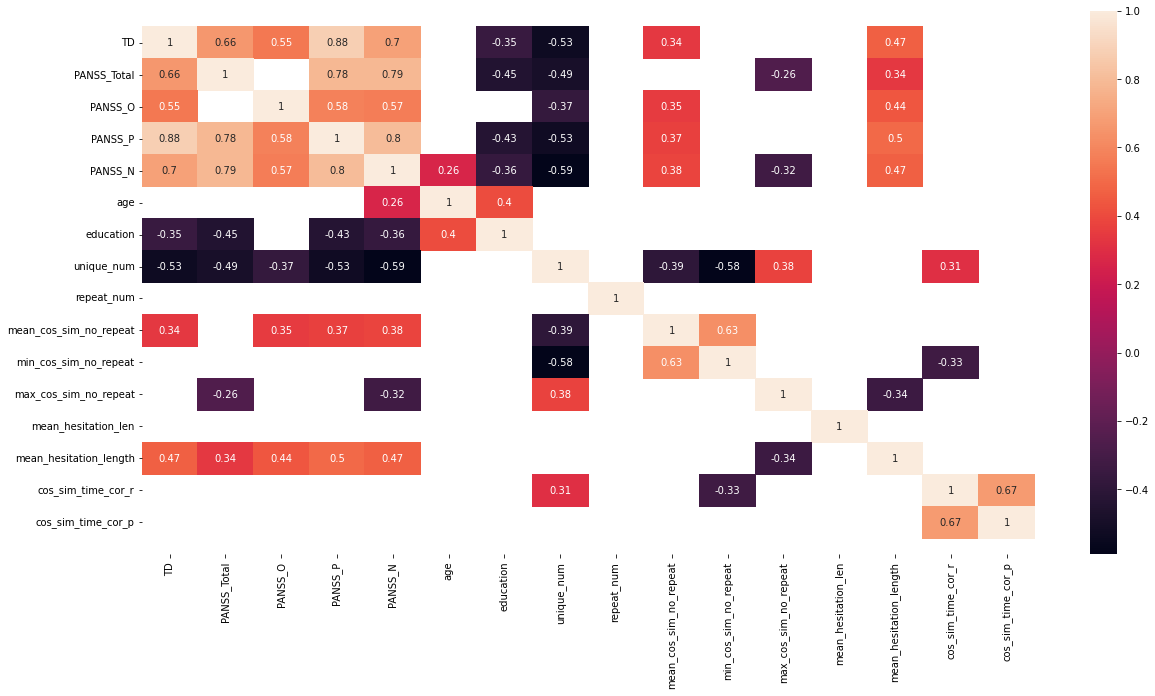

In [214]:
plt.figure(figsize=(20,10))
sns.heatmap(animals[corr_test + params].corr(), annot=True, mask = mask)
plt.yticks(rotation = 0)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!;

In [215]:
calculate_pvalues(animals[corr_test + params])

,TD,PANSS_Total,PANSS_O,PANSS_P,PANSS_N,age,education,unique_num,repeat_num,mean_cos_sim_no_repeat,min_cos_sim_no_repeat,max_cos_sim_no_repeat,mean_hesitation_len,mean_hesitation_length,cos_sim_time_cor_r,cos_sim_time_cor_p
TD,0,0,0.0002,0,0,0.1503,0.0422,0.0002,0.6719,0.0451,0.1159,0.4412,0.5196,0.0018,0.7166,0.7247
PANSS_Total,0,0,0.1011,0,0,0.1179,0.0055,0.0038,0.3148,0.3443,0.253,0.0374,0.511,0.0206,0.4202,0.0933
PANSS_O,0.0002,0.1011,0,0,0.0001,0.6176,0.0843,0.0131,0.2975,0.0231,0.1617,0.54,0.9035,0.003,0.4681,0.8932
PANSS_P,0,0,0,0,0,0.1466,0.0087,0.0006,0.5337,0.0359,0.1364,0.2926,0.679,0.0006,0.4367,0.2389
PANSS_N,0,0,0.0001,0,0,0.019,0.0353,0.0001,0.7356,0.0298,0.1629,0.017,0.6894,0.0009,0.6425,0.478
age,0.1503,0.1179,0.6176,0.1466,0.019,0,0.005,0.0986,0.0654,0.3114,0.1294,0.112,0.6779,0.2672,0.8402,0.1955
education,0.0422,0.0055,0.0843,0.0087,0.0353,0.005,0,0.1008,0.422,0.7774,0.8905,0.9759,0.2447,0.9294,0.2724,0.4174
unique_num,0.0002,0.0038,0.0131,0.0006,0.0001,0.0986,0.1008,0,0.8703,0.0305,0.0002,0.0043,0.1361,0.0842,0.0465,0.4798
repeat_num,0.6719,0.3148,0.2975,0.5337,0.7356,0.0654,0.422,0.8703,0,0.5348,0.8331,0.5256,0.981,0.2811,0.8284,0.7234
mean_cos_sim_no_repeat,0.0451,0.3443,0.0231,0.0359,0.0298,0.3114,0.7774,0.0305,0.5348,0,0,0.5851,0.9306,0.584,0.5131,0.9627
